In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
sns.set_color_codes()
C0, C1 = sns.color_palette()[:2]

#### Code 13.1

In [3]:
a = 3.5        # average morning wait time
b = -1.        # average difference afternoon wait time
sigma_a = 1.   # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7     # correlation between intercepts and slopes

#### Code 13.2

In [4]:
Mu = [a, b]  

#### Code 13.3

In [5]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

#### Code 13.4

The code 13.4 and the related comment in the book is particular to R and not relevant for Python.

#### Code 13.5

In [6]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 13.6

In [7]:
N_cafes = 20

#### Code 13.7

In [8]:
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

#### Code 13.8

In [9]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

#### Code 13.9

Instead of using confidence region ellipses (Seaborn doesn't have this functionality)
we'll be using KDEs. To make the kde smoother we will use a sample size larger than the one `vary_effects`

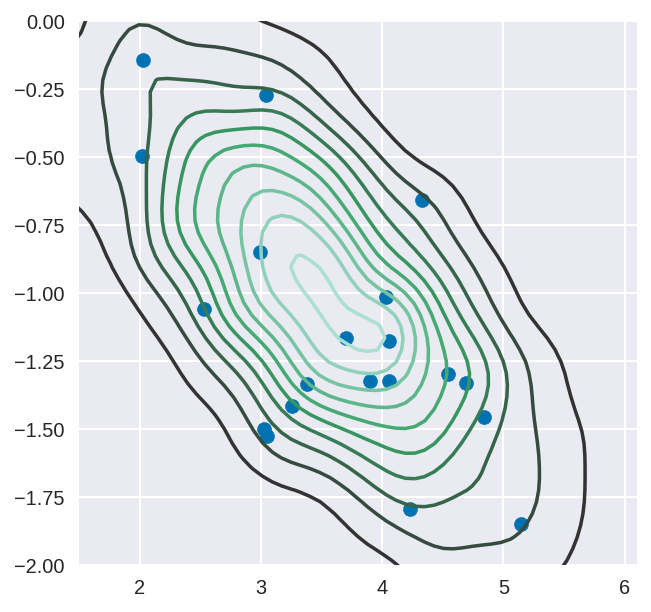

In [10]:
np.random.seed(42)
vary_effects_larger = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=2000)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(vary_effects_larger, ax=ax)  # KDE plot (substitute for confidence ellipses)
ax.scatter(a_cafe, b_cafe)
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2, 0);

#### Code 13.10

In [11]:
N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))

#### Code 13.11

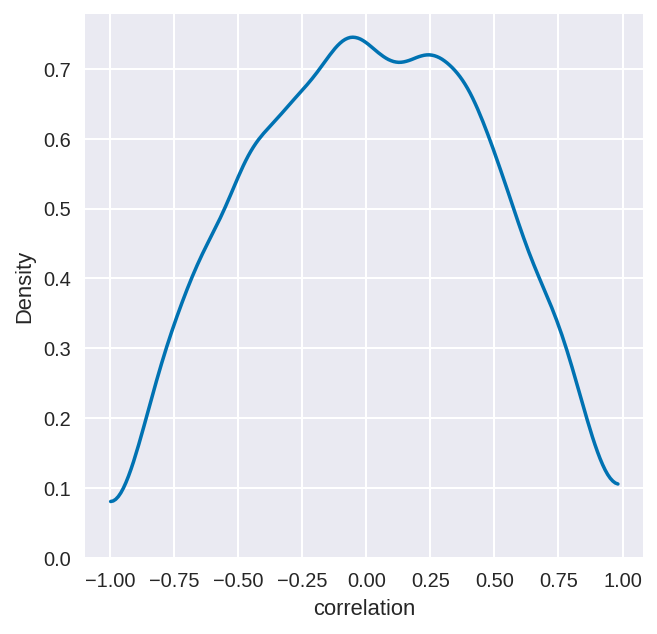

In [12]:
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.kdeplot(R, ax=ax);
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

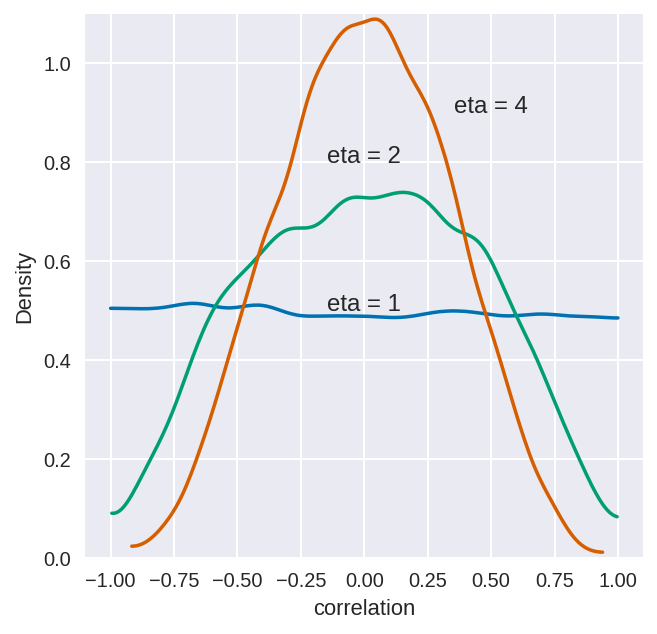

In [13]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, .5], [0, .8], [.5, .9]]
for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(R, ax=ax);
    ax.text(loc[0], loc[1], 'eta = %s'%(eta), horizontalalignment='center')

ax.set_ylim(0, 1.1)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

#### Code 13.12

In [14]:
cafe_idx = d['cafe'].values
with pm.Model() as m_13_1:
    sd_dist = pm.HalfCauchy.dist(beta=2) # This is the same as sigma_cafe ~ dcauchy(0,2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)  # prior for average intercept and slope
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    sd = pm.HalfCauchy('sigma', beta=2)      # prior stddev within cafes
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d['wait'])  # likelihood
    trace_13_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 7000/7000 [01:00<00:00, 115.24it/s]


For complicate model it is always good to do more checks:

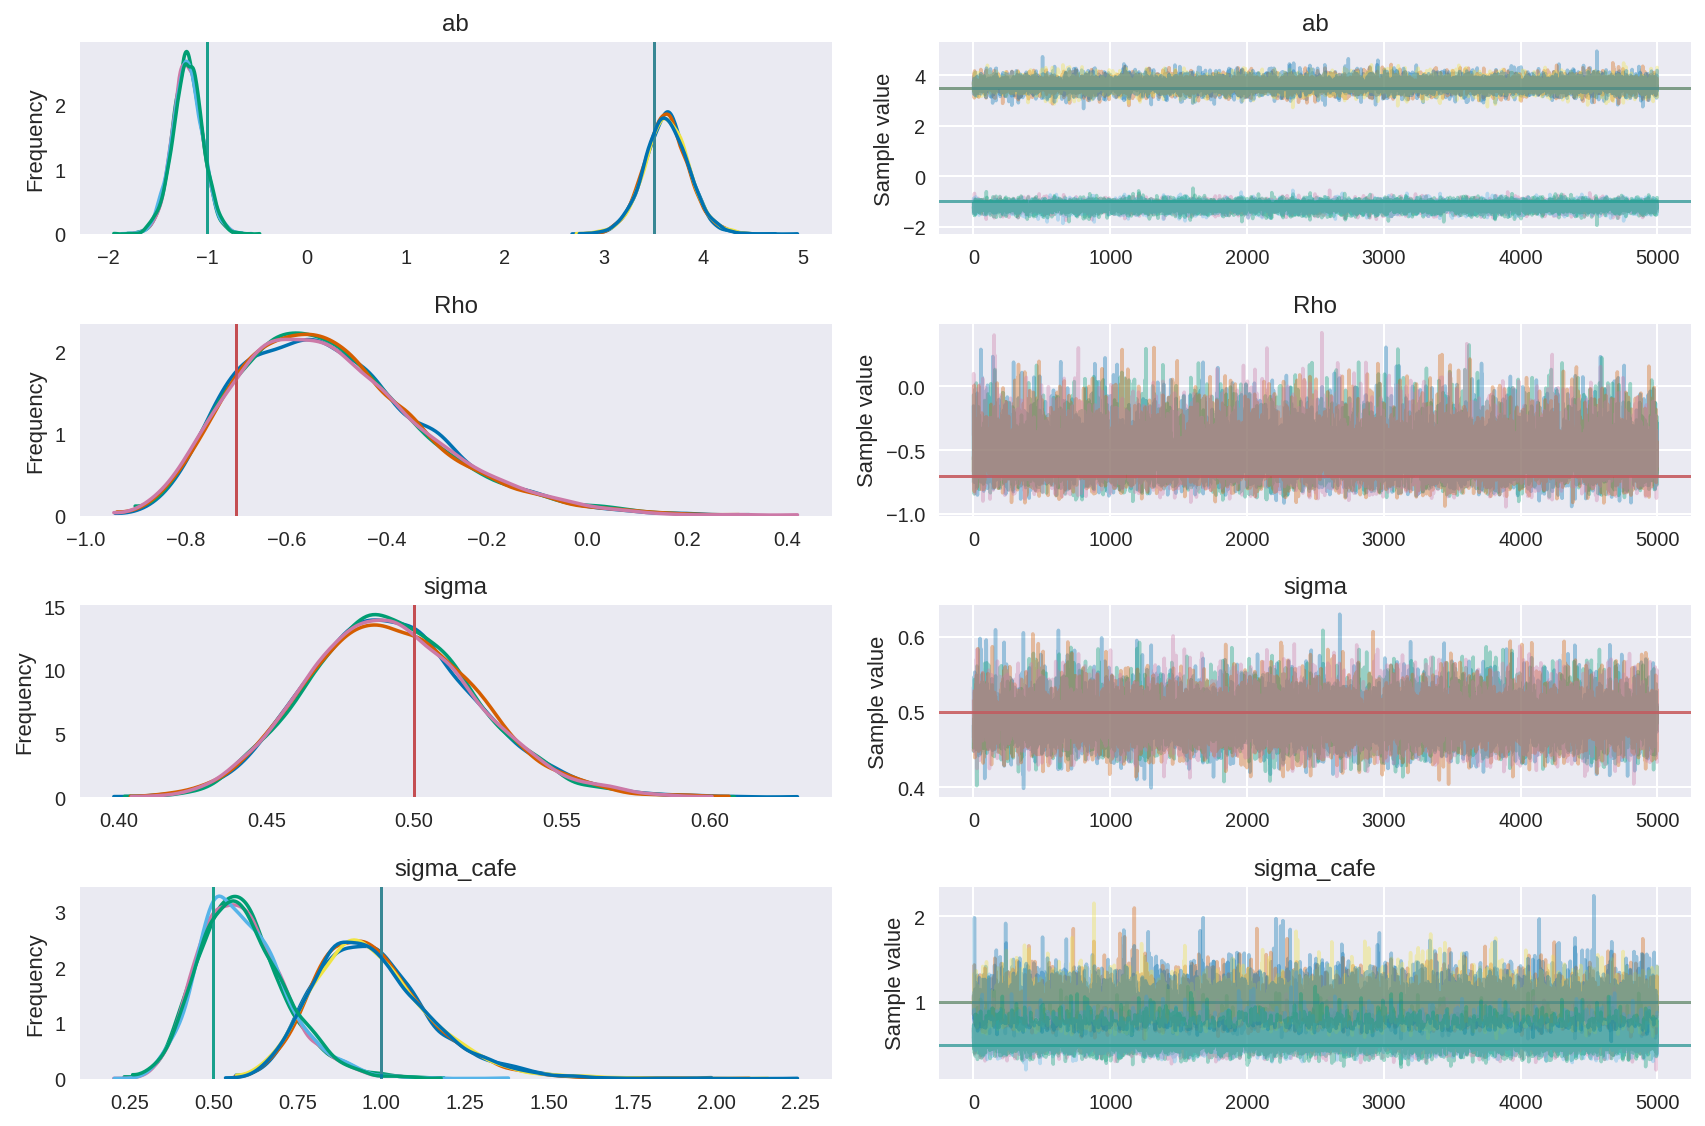

In [15]:
pm.traceplot(trace_13_1, varnames=['ab', 'Rho', 'sigma', 'sigma_cafe'],
             lines={"ab": Mu,
                    "Rho": rho,
                    "sigma": sigma,
                    "sigma_cafe": sigmas});

#### Code 13.13

In [16]:
post = pm.trace_to_dataframe(trace_13_1)

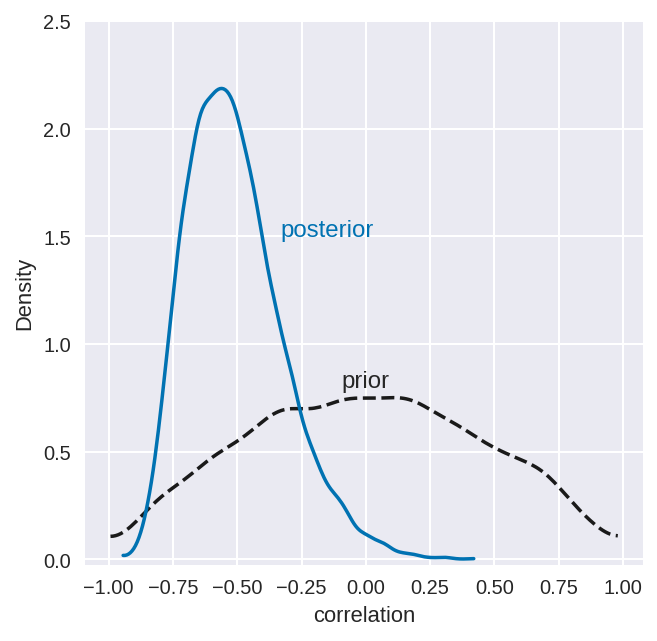

In [17]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
pm.kdeplot(R, ax=ax, color='k', linestyle='--')
ax.text(0, .8, 'prior', horizontalalignment='center')
pm.kdeplot(trace_13_1['Rho'], ax=ax, color=C0)
ax.text(-.15, 1.5, 'posterior', color=C0, horizontalalignment='center')
ax.set_ylim(-.025, 2.5)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

#### Code 13.14

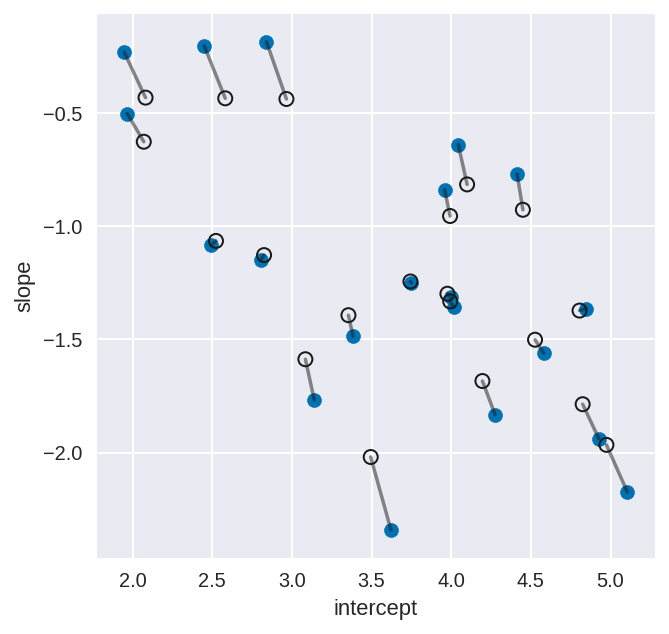

In [18]:
# compute unpooled estimates directly from data
a1b1 = (d.groupby(['afternoon', 'cafe'])
        .agg('mean')
        .unstack(level=0)
        .values)
a1 = a1b1[:, 0]
b1 = a1b1[:, 1] - a1

# extract posterior means of partially pooled estimates
a2b2 = trace_13_1['ab_cafe'].mean(axis=0)
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(a1, b1)
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1)

ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept')
ax.set_ylabel('slope');

#### Code 13.15

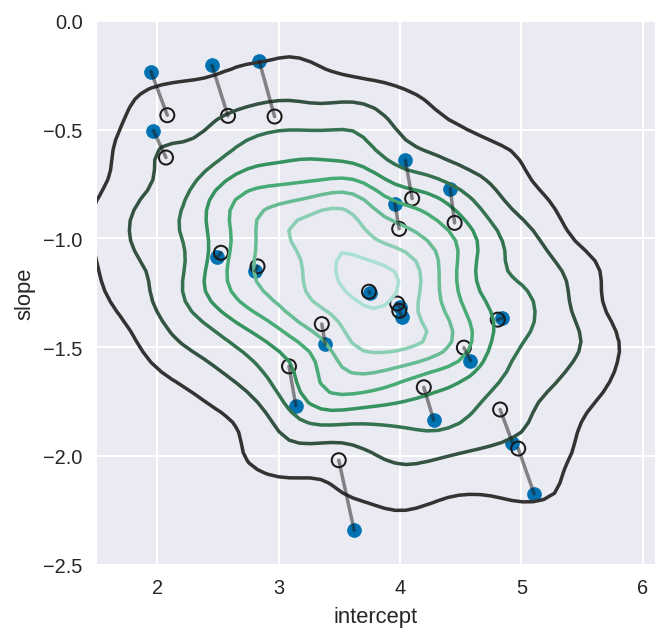

In [21]:
# compute posterior mean bivariate Gaussian
Mu_est = trace_13_1['ab'].mean(axis=0)
Chol_cov = trace_13_1['chol_cov'].mean(axis=0)
L_chol = np.zeros((2, 2))
L_chol[np.triu_indices(2, 0)] = Chol_cov
Sigma_est = np.dot(L_chol, L_chol.T)
# draw contours
contours = np.random.multivariate_normal(mean=Mu_est, cov=Sigma_est, size=5000)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.kdeplot(contours, ax=ax)
ax.scatter(a1, b1)
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept')
ax.set_ylabel('slope')
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2.5, 0);

#### Code 13.16

In [22]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

#### Code 13.17

In [25]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

#### Code 13.18

#### Code 13.19

#### Code 13.20

#### Code 13.21

#### Code 13.22

#### Code 13.23

#### Code 13.24

#### Code 13.25

#### Code 13.26

#### Code 13.27

#### Code 13.28

#### Code 13.29

#### Code 13.30

#### Code 13.31

#### Code 13.32

#### Code 13.33

#### Code 13.34

#### Code 13.35

#### Code 13.36

#### Code 13.37

In [20]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running Ubuntu 16.04 and using:
Python 3.5.2
IPython 6.2.1
PyMC3 3.2
NumPy 1.13.3
SciPy 0.19.1
Matplotlib 2.1.0+224.g95805d2
Seaborn 0.7.1

